In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from keras.layers import Input,Dense,Conv2D,MaxPooling2D,UpSampling2D, BatchNormalization
from keras.models import Model
from keras.optimizers import RMSprop

Necessary libraries is imported.

In [2]:
def load_data(source,target):
    
    img_size = (128,128)
    imgs_source = []
    imgs_target = []
    
    num_of_samples = 2000
    i = 0
    for _, _,filenames in os.walk('C:/augmented/source/'):
        for filename in filenames:
            i += 1
            if(i>num_of_samples):
                break
            else:
                img_source = cv2.imread(os.path.join(source,filename),cv2.IMREAD_GRAYSCALE)
                img_target = cv2.imread(os.path.join(target, filename),cv2.IMREAD_GRAYSCALE)
                
                img_source = cv2.resize(img_source,img_size)
                img_target = cv2.resize(img_target,img_size)
                
                img_source = np.array(img_source)/255
                img_target = np.array(img_target)/255
            
                imgs_source.append(img_source)
                imgs_target.append(img_target)
    return imgs_source, imgs_target

load_data function is for loading datas for usage with deep learning. The logic behind the function is, gets 2000 images from directory from the computer. After that with the help of opencv library, images is resized in 128x128 in grayscale and images turned into an array, the datas in array is in the range of 0-1 (tensor) and empty lists is totally filled with these arrays. Finally the source and target datas is returned.

In [3]:
dir_source = "C:/augmented/source"
dir_target = "C:/augmented/target"

source, target = load_data(dir_source,dir_target)

Address of the directories.

In [4]:

def add_noise(image):
    row,col= image.shape
    mean = 0
    sigma = 1
    gauss = np.random.normal(mean,sigma,(row,col))
    gauss = gauss.reshape(row,col)
    noisy = image + gauss*0.07
    return noisy


add_noise function is for adding noise to images. Main purpose of this project is reducing noise from images.

In [5]:
noised_df= []

for img in source:
    noisy= add_noise(img)
    noised_df.append(noisy)

A for loop structure for adding noise for every image.

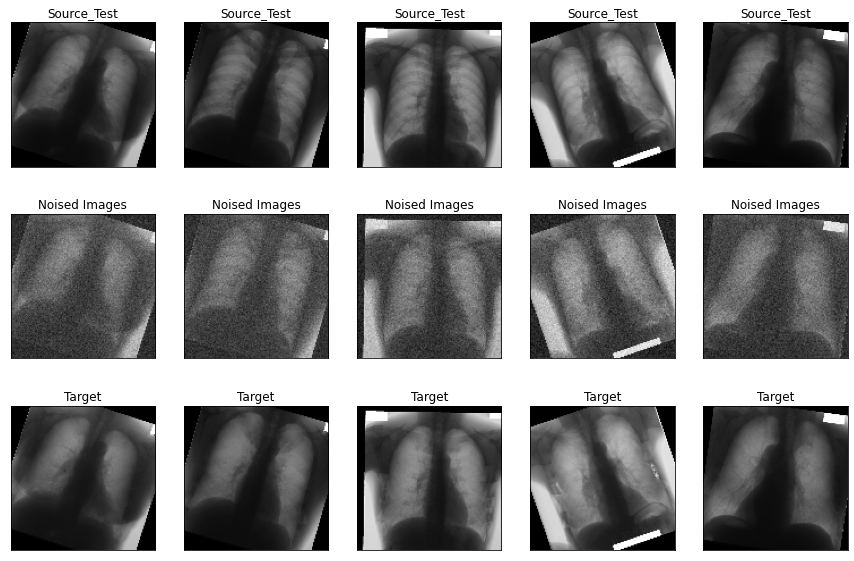

In [6]:
plt.figure(figsize=(15,10))

for i in range(5):
    ax = plt.subplot(3, 5, i+1)
    plt.imshow(source[i].reshape(128,128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title('Source_Test')

    ax = plt.subplot(3, 5, i+6)
    plt.imshow(noised_df[i].reshape(128,128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title('Noised Images')
    
    ax = plt.subplot(3, 5, i+11)
    plt.imshow(target[i].reshape(128,128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title('Target')
plt.show()

Data visualization with matplotlib.

In [7]:

image_shape = (128,128,1)
    
target = np.array(target).reshape(-1,128,128,1)
noised_df= np.array(noised_df).reshape(-1,128,128,1)
    
source_train, source_test, target_train, target_test = train_test_split(noised_df, target,test_size=0.20,random_state=1)


Train and test data split %80 of train, %20 of test splitting. Also, turning array into a vector for training.

In [8]:
print(f"Source Train data shape = {source_train.shape}")
print(f"Source Test data shape = {source_test.shape}")
print(f"Target Train data shape = {target_train.shape}")
print(f"Target Test data shape = {target_test.shape}")

Source Train data shape = (1600, 128, 128, 1)
Source Test data shape = (400, 128, 128, 1)
Target Train data shape = (1600, 128, 128, 1)
Target Test data shape = (400, 128, 128, 1)


In [9]:
def autoencoder(input_img):
    #encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) 
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) 
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) 
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) 
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) 
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)


    #decoder
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3) 
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    up1 = UpSampling2D((2,2))(conv4) 
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1) 
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    up2 = UpSampling2D((2,2))(conv5) 
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) 
    return decoded

autoencoder function is for building the model. The model is based on encoder and decoder part. Encoder part starts to shrink 128x128 images into 32x32. After that decoder part builds the images from 32x32 to 128x128.

In [10]:
input_img = Input(shape = image_shape)
autoencoder = Model(input_img, autoencoder(input_img))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

The model compiled with Mean Square Error (MSE) for the optimizer, RMSprop is used. RMSprop is Root Mean Square Propagation. The main idea of the RMSprop is the normalization of the gradient by the square root of the mean of squares. Furthermore the loss and optimizer will work in an order.

In [11]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0     

In [12]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


Checking for whether the GPU is available. For this training, NVIDIA GTX1650Ti and Intel I5 10300H is used with 16GB of RAM.

In [13]:
n_epoch = 64
n_batch = 32

autoencoder_train = autoencoder.fit(source_train, target_train,
                                    epochs = n_epoch,
                                    batch_size = n_batch,
                                    verbose = 0,
                                    validation_data = (source_test, target_test))

Fitting the model, epoch and batch size can be seen. Source test and target test datas is used for validation, for training, source train and target train is used.

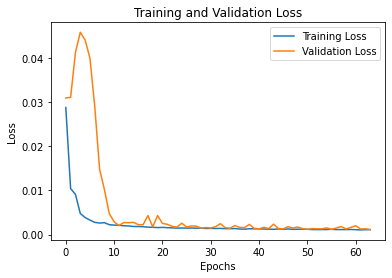

In [14]:
n = np.arange(0, n_epoch)
plt.figure()
plt.plot(n, autoencoder_train.history['loss'], label = 'Training Loss')
plt.plot(n, autoencoder_train.history['val_loss'], label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

Visualition of losses in training.

In [15]:
pred = autoencoder.predict(source_test)

13/13 [==============================] - 1s 47ms/step


Making predictions from source test with the trained model.

Text(0.5, 1.0, 'Source_Test')

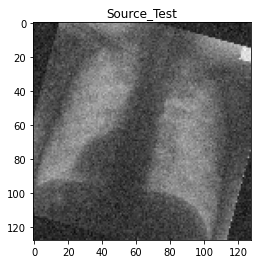

In [16]:

plt.imshow(source_test[1].reshape(128,128))
plt.gray()
plt.title('Source_Test')


Text(0.5, 1.0, 'Predicted')

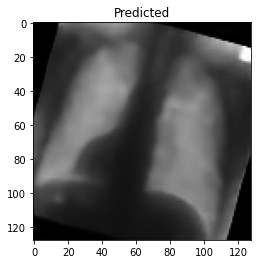

In [17]:
plt.imshow(pred[1].reshape(128,128))
plt.gray()
plt.title('Predicted')

Text(0.5, 1.0, 'Gaussian Blur with 7x7 kernel')

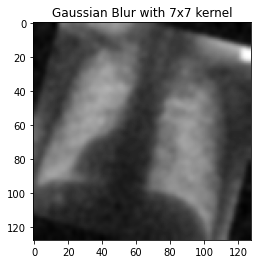

In [18]:
gaussian_blur = cv2.GaussianBlur(source_test[1],(7,7),0)
plt.imshow(gaussian_blur)
plt.title('Gaussian Blur with 7x7 kernel')

To reducing the noise Gaussian Blur is highly used filter in image processing but the model reduced the noise better than Gaussian Blur.

Text(0.5, 1.0, 'Target Image')

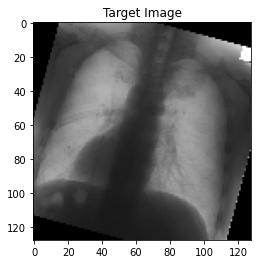

In [19]:
plt.imshow(target_test[1].reshape(128,128))
plt.gray()
plt.title('Target Image')

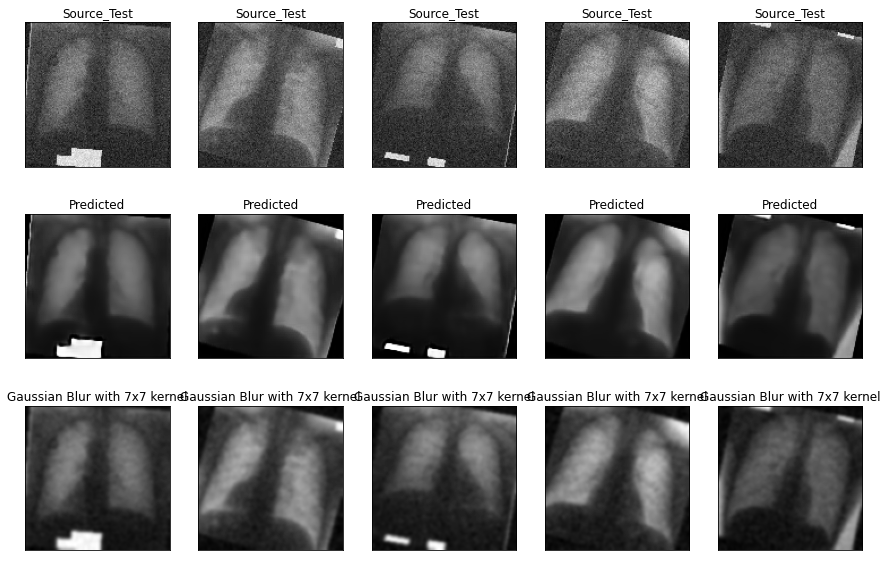

In [31]:
plt.figure(figsize=(15,10))

for i in range(5):
    ax = plt.subplot(3, 5, i+1)
    plt.imshow(source_test[i].reshape(128,128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title('Source_Test')

    ax = plt.subplot(3, 5, i+6)
    plt.imshow(pred[i].reshape(128,128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title('Predicted')
    
    ax = plt.subplot(3, 5, i+11)
    plt.imshow(cv2.GaussianBlur(source_test[i],(7,7),0).reshape(128,128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title('Gaussian Blur with 7x7 kernel')

plt.show()

Visualition of the datas for comparing with Gaussian Blur.

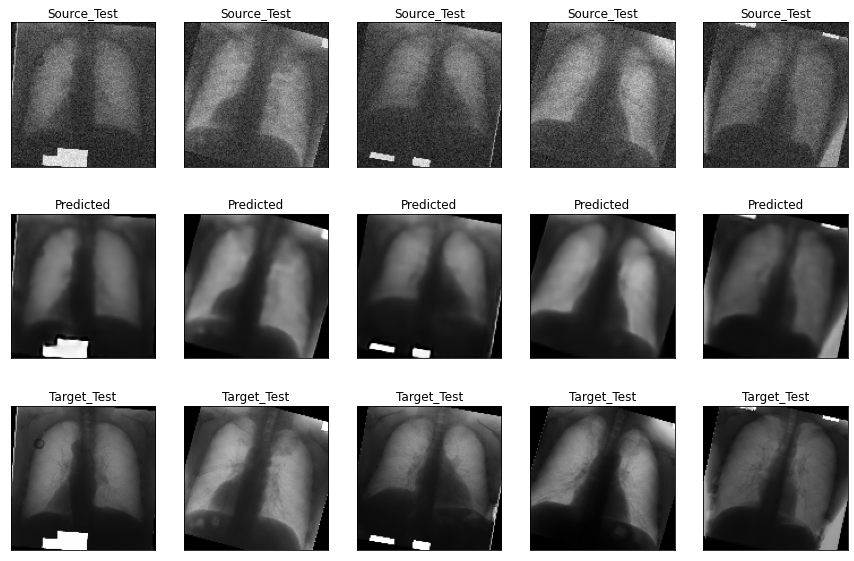

In [34]:
plt.figure(figsize=(15,10))

for i in range(5):
    ax = plt.subplot(3, 5, i+1)
    plt.imshow(source_test[i].reshape(128,128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title('Source_Test')

    ax = plt.subplot(3, 5, i+6)
    plt.imshow(pred[i].reshape(128,128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title('Predicted')
    
    ax = plt.subplot(3, 5, i+11)
    plt.imshow(target_test[i].reshape(128,128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title('Target_Test')

Visualition of the datas for comparing target datas.